In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # 스레드 수를 1로 설정
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
from src.pre_process.feature_add import FeatureAddition
from src.pre_process.feature_duplicate import FeatureDuplication

In [18]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'

train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [19]:
train_dupli = FeatureDuplication(train_data).get_data()
train_dupli.head()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0


In [20]:
train_dupli["_type"]= "train"
test_data["_type"]= "test"

concat_df = pd.concat([train_dupli,test_data],axis=0)
df= FeatureAddition(concat_df).get_data()
df.drop(columns='index', inplace=True)

In [21]:
train_df = df[df['_type']=='train']
test_df = df[df['_type']=='test']

---

### 위도 / 경도 격자 분리 후 각 구역 설정 

- 행정동 데이터 대체 컬럼 만들기

In [22]:
location_df = df[['latitude','longitude','apt_idx']].groupby(['apt_idx']).mean()

In [23]:
import matplotlib.pyplot as plt
from pyproj import Proj
from pyproj import Transformer

In [24]:
# UTM 좌표계로 변환하는 함수
def latlon_to_utm(lat, lon):
    # WGS84에서 UTM으로 변환하는 Transformer 생성 (zone은 지역에 맞게 설정)
    transformer = Transformer.from_crs("epsg:4326", "epsg:32652")  # 여기서 zone은 52로 설정 (한국 지역 예시)
    utm_x, utm_y = transformer.transform(lat, lon)
    return utm_x, utm_y

In [25]:
location_df['utm_x'], location_df['utm_y']= zip(
    *location_df.apply(lambda row: latlon_to_utm(row['latitude'],row['longitude']), axis=1))

location_df['grid_x'] = (location_df['utm_x'] // 5000).astype(int)
location_df['grid_y'] = (location_df['utm_y'] // 5000).astype(int)

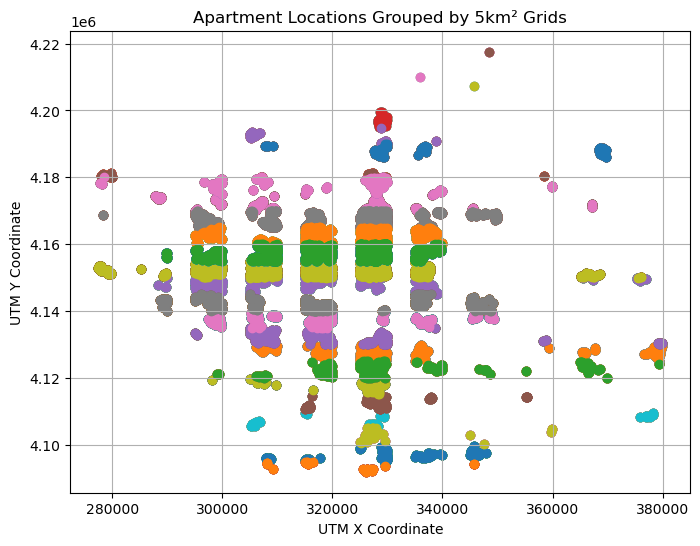

In [27]:
plt.figure(figsize=(8,6))

# 각 격자를 다른 색으로 표현하기 위해 unique한 grid 셀을 찾아 표시
unique_grids = location_df[['grid_x','grid_y']].drop_duplicates()

for _, grid in unique_grids.iterrows():
    # 해당 그리드에 속하는 데이터 포인트 필터링
    grid_data = location_df[(location_df['grid_x']) & (location_df['grid_y'] == grid['grid_y'])]
    plt.scatter(grid_data['utm_x'],grid_data['utm_y'], 
                label=f'Grid ({grid['grid_x']}, {grid['grid_y']})')
# 그래프 제목 및 레이블 설정
plt.title('Apartment Locations Grouped by 5km² Grids')
plt.xlabel('UTM X Coordinate')
plt.ylabel('UTM Y Coordinate')
# plt.legend()
plt.grid(True)
plt.show()

In [28]:
location_df

,latitude,longitude,utm_x,utm_y,grid_x,grid_y
apt_idx,,,,,,
0,37.054314,127.045216,326185.513212,4.102685e+06,65,820
1,36.964647,127.055847,326927.596059,4.092717e+06,65,818
2,36.972390,127.084514,329497.144808,4.093524e+06,65,818
3,36.965423,127.048779,326300.076453,4.092816e+06,65,818
4,36.957089,127.047449,326162.673906,4.091893e+06,65,818
...,...,...,...,...,...,...
18671,37.540437,127.145738,336182.617601,4.156443e+06,67,831
18672,37.499548,127.144838,336013.634073,4.151908e+06,67,830
18673,37.463234,126.642899,291538.112869,4.148871e+06,58,829


In [29]:
unique_grids

,grid_x,grid_y
apt_idx,,
0,65,820
1,65,818
12,63,819
15,63,818
19,62,819
...,...,...
17148,59,830
17355,59,831
17633,58,831


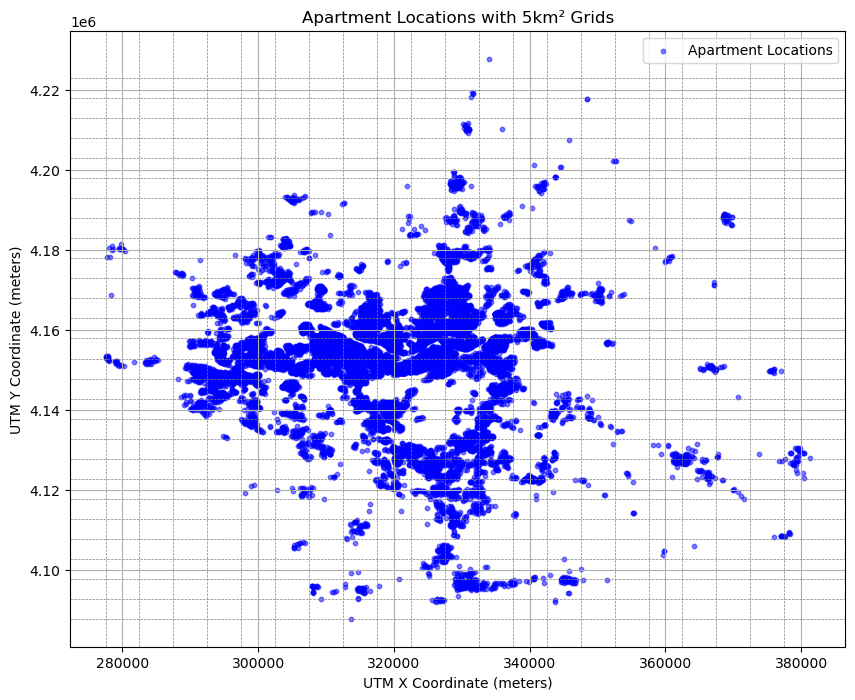

In [31]:
# 아파트 위치를 산점도로 그리기
plt.figure(figsize=(10, 8))
plt.scatter(location_df['utm_x'], location_df['utm_y'], c='blue', s=10, label='Apartment Locations', alpha=0.5)

# 격자 그리기 (5km 간격의 선을 그립니다)
min_x, max_x = location_df['utm_x'].min(), location_df['utm_x'].max()
min_y, max_y = location_df['utm_y'].min(), location_df['utm_y'].max()

# X축과 Y축에 5000미터 간격으로 선을 그림
for x in np.arange(min_x, max_x, 5000):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
for y in np.arange(min_y, max_y, 5000):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# 그래프 제목 및 레이블 설정
plt.title('Apartment Locations with 5km² Grids')
plt.xlabel('UTM X Coordinate (meters)')
plt.ylabel('UTM Y Coordinate (meters)')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\com\AppData\Local\Temp\ipykernel_2352\1663793217.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 253)  # 253개의 색상으로 설정


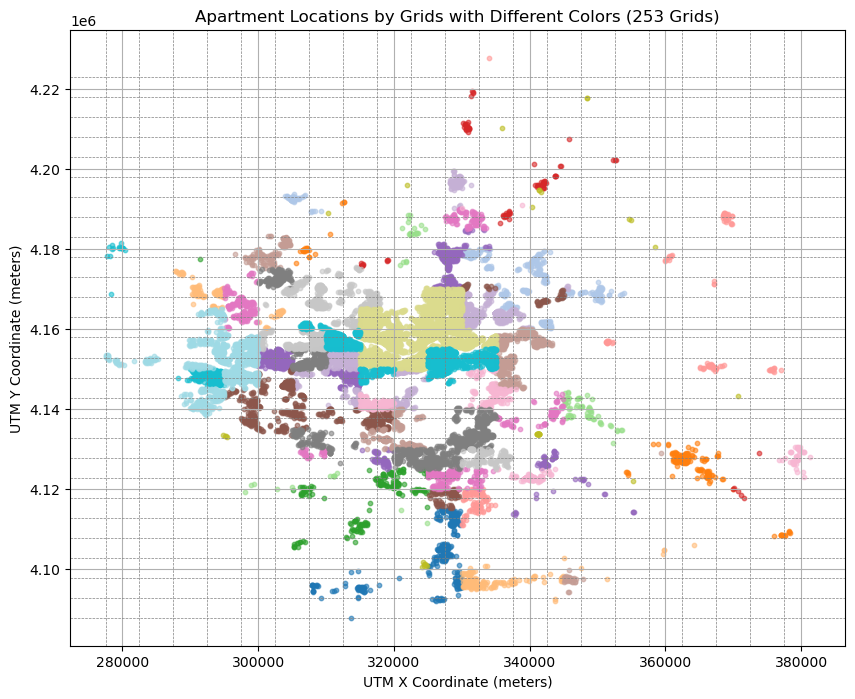

In [32]:
# 고유한 그리드마다 다른 색상을 적용하기 위해 고유 그리드를 인덱스로 설정
location_df['grid_id'] = location_df['grid_x'].astype(str) + '_' + location_df['grid_y'].astype(str)
unique_grids = location_df['grid_id'].unique()

# 각 그리드에 다른 색상을 할당 (253개의 색상을 가지는 cmap 사용)
colors = plt.cm.get_cmap('tab20', 253)  # 253개의 색상으로 설정

# 아파트 위치를 산점도로 그리고, 각 그리드에 맞는 색상 적용
plt.figure(figsize=(10, 8))
for i, grid_id in enumerate(unique_grids):
    grid_data = location_df[location_df['grid_id'] == grid_id]
    plt.scatter(grid_data['utm_x'], grid_data['utm_y'], color=colors(i), label=f"Grid {grid_id}", s=10, alpha=0.6)

# 격자 그리기 (5km 간격의 선을 그립니다)
min_x, max_x = location_df['utm_x'].min(), location_df['utm_x'].max()
min_y, max_y = location_df['utm_y'].min(), location_df['utm_y'].max()

# X축과 Y축에 5000미터 간격으로 선을 그림
for x in np.arange(min_x, max_x, 5000):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
for y in np.arange(min_y, max_y, 5000):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# 그래프 제목 및 레이블 설정
plt.title('Apartment Locations by Grids with Different Colors (253 Grids)')
plt.xlabel('UTM X Coordinate (meters)')
plt.ylabel('UTM Y Coordinate (meters)')
plt.grid(True)
plt.show()


In [82]:
pd.set_option('display.max_rows', None)

grid_apt_counts = location_df.groupby(['grid_x','grid_y']).size().reset_index(name='apartment_count')

grid_apt_counts.sort_values(['apartment_count'])

,grid_x,grid_y,apartment_count
34,60,823,1
91,63,823,1
21,58,835,1
22,59,823,1
224,71,824,1
225,71,825,1
243,74,825,1
228,71,836,1
242,74,824,1
234,73,823,1


각 구역별로 나눠진걸 확인할 수 있었다.

이제 조금 더 상세한 비교를 위해 각 격자 구역별 전세가 추이를 확인해보겠다.

---

In [43]:
# 'apt_idx'를 기준으로 'deposit'의 평균을 구함
deposit_mean = df.groupby('apt_idx')['deposit'].mean().reset_index()

# 'apt_idx'를 기준으로 location_df와 병합하여 평균 deposit 값을 location_df에 추가
location_df = location_df.merge(deposit_mean, on='apt_idx', how='left')

# 'deposit_mean' 열을 'deposit'으로 이름 변경
location_df.rename(columns={'deposit': 'deposit_mean'}, inplace=True)


In [44]:
location_df.head()

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65_820,32823.103734
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65_818,4750.000000
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65_818,4818.181818
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65_818,22361.570248
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65_818,4658.333333


In [45]:
location_df['grid_id'] = (location_df['grid_x'].astype(str) + location_df['grid_y'].astype(str)).astype(int)

location_df.head()

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65820,32823.103734
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65818,4750.000000
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65818,4818.181818
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65818,22361.570248
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65818,4658.333333


In [55]:
grid_deposit_mean = location_df.groupby(['grid_id'])['deposit_mean'].mean().reset_index()

grid_deposit_mean

,grid_id,deposit_mean
0,55830,18876.882821
1,55833,5125.000000
2,55835,14950.056117
3,55836,8500.000000
4,56830,20280.267704
...,...,...
248,75826,15014.051163
249,75829,16079.507167
250,75830,14233.333333
251,76824,10592.521994


array([[<Axes: title={'center': 'deposit_mean'}>]], dtype=object)

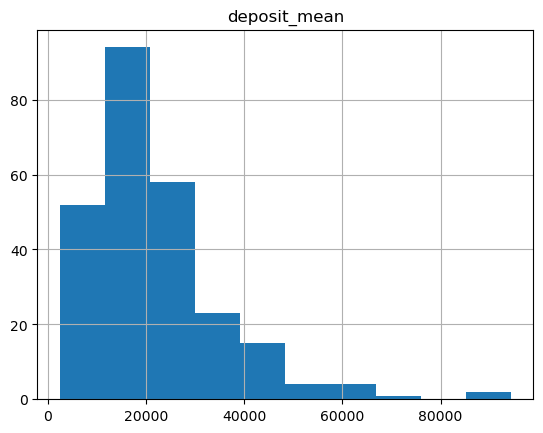

In [58]:
grid_deposit_mean.hist()

array([[<Axes: title={'center': 'deposit_mean'}>,
        <Axes: title={'center': 'log_deposit_mean'}>]], dtype=object)

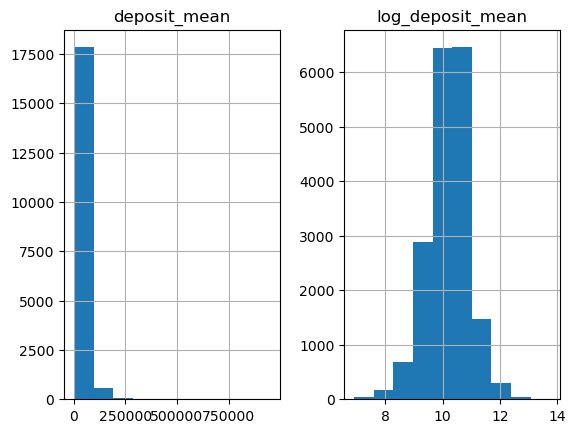

In [62]:
location_df['log_deposit_mean'] = np.log(location_df['deposit_mean'])
location_df[['deposit_mean','log_deposit_mean']].hist()

In [63]:
location_df.head()

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean,log_deposit_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65820,32823.103734,10.398888
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65818,4750.000000,8.465900
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65818,4818.181818,8.480152
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65818,22361.570248,10.015099
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65818,4658.333333,8.446413


In [64]:
# grid_x, grid_y 기준으로 deposit_mean의 평균을 계산
grid_deposit_mean = location_df.groupby(['grid_x', 'grid_y'])['deposit_mean'].mean().reset_index()

# location_df와 grid_deposit_mean을 병합하여 각 아파트의 좌표와 격자별 전세가 평균을 결합
merged_df = pd.merge(location_df, grid_deposit_mean, on=['grid_x', 'grid_y'], how='left', suffixes=('', '_grid_mean'))

array([[<Axes: title={'center': 'grid_mean'}>,
        <Axes: title={'center': 'log_grid_mean'}>]], dtype=object)

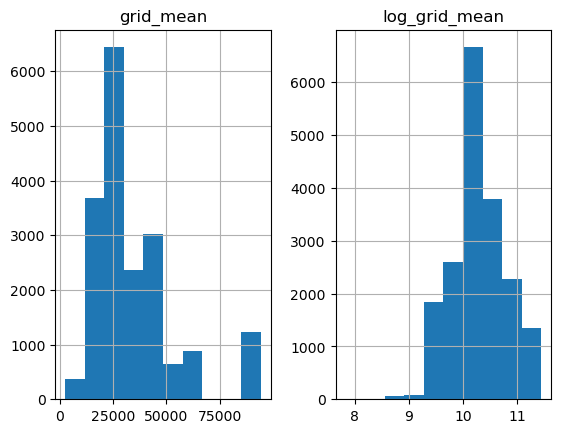

In [81]:
merged_df = merged_df.rename(columns={'deposit_mean_grid_mean': 'grid_mean'})
merged_df['log_grid_mean'] = np.log(merged_df['grid_mean'])
merged_df[['grid_mean','log_grid_mean']].hist()

In [75]:
merged_df

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean,log_deposit_mean,grid_mean,log_grid_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65820,32823.103734,10.398888,14932.327370,9.611284
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65818,4750.000000,8.465900,10750.064922,9.282667
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65818,4818.181818,8.480152,10750.064922,9.282667
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65818,22361.570248,10.015099,10750.064922,9.282667
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65818,4658.333333,8.446413,10750.064922,9.282667
...,...,...,...,...,...,...,...,...,...,...,...,...
18671,18671,37.540437,127.145738,336182.617601,4.156443e+06,67,831,67831,NaN,NaN,39515.060301,10.584437
18672,18672,37.499548,127.144838,336013.634073,4.151908e+06,67,830,67830,NaN,NaN,43062.817041,10.670415
18673,18673,37.463234,126.642899,291538.112869,4.148871e+06,58,829,58829,NaN,NaN,14351.160222,9.571586
18674,18674,37.459061,126.674991,294365.330414,4.148338e+06,58,829,58829,NaN,NaN,14351.160222,9.571586


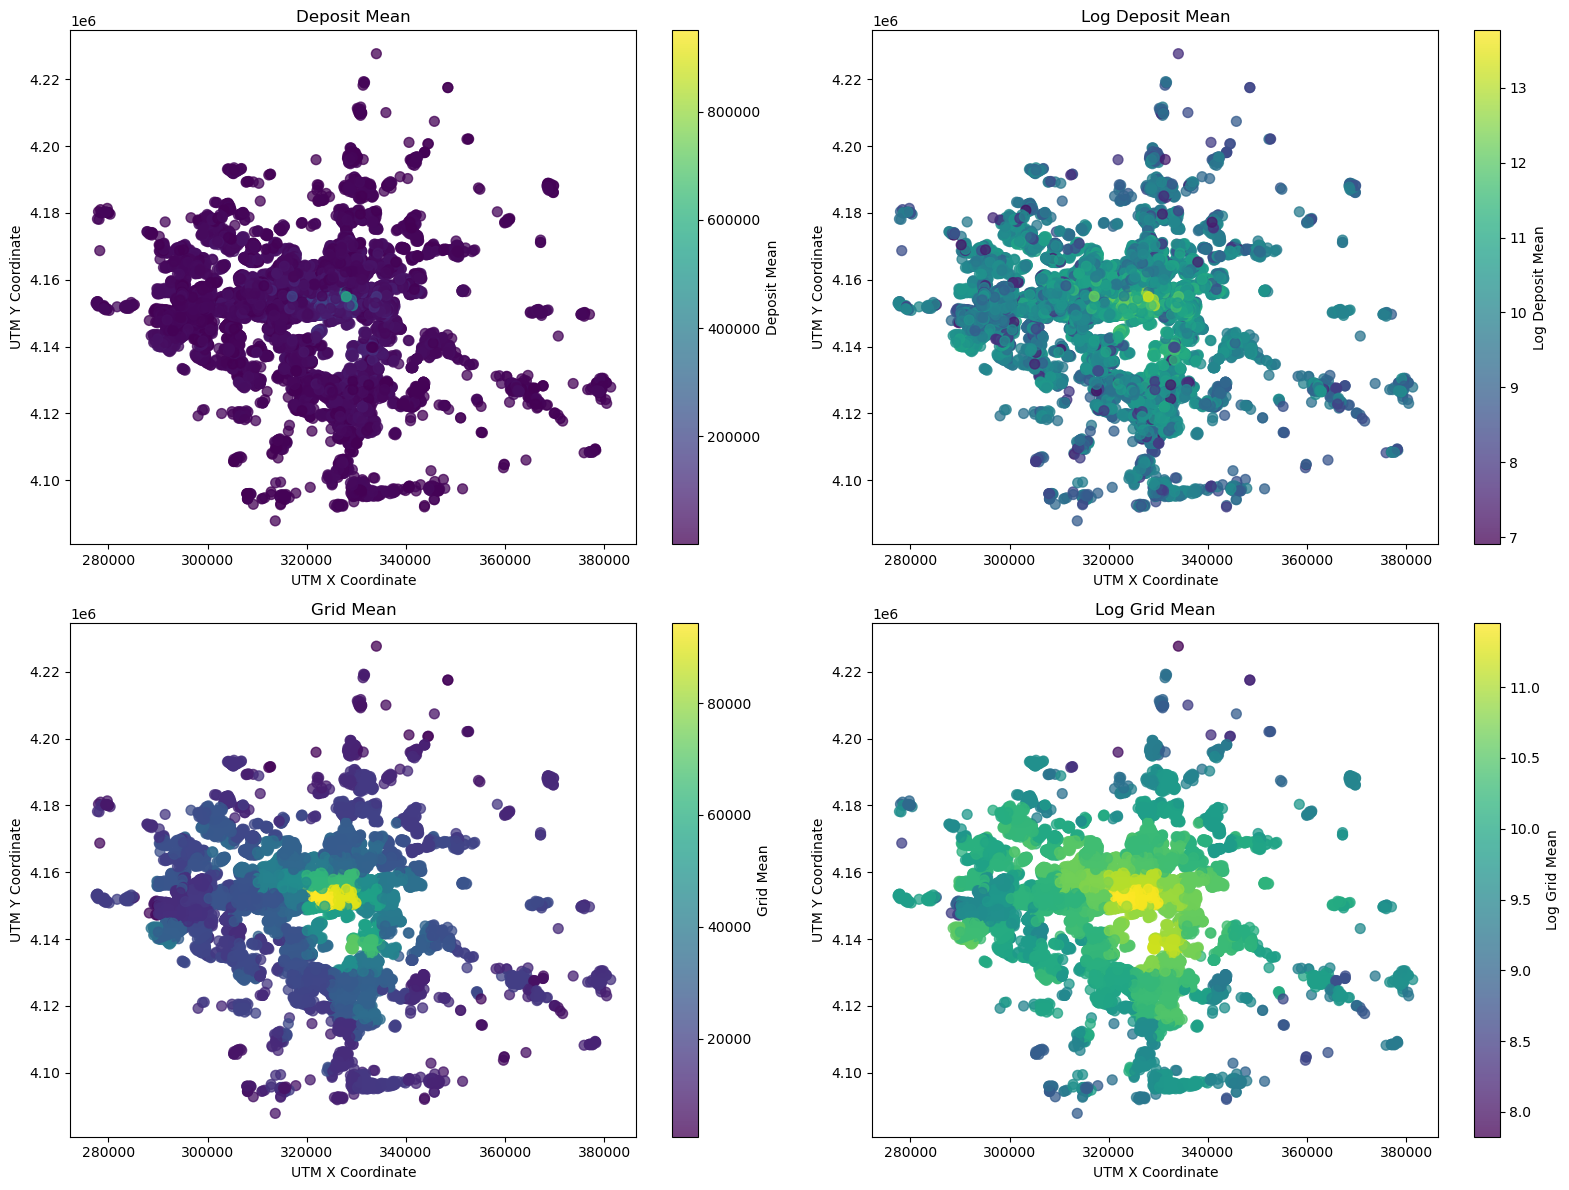

In [80]:
columns_to_plot = ['deposit_mean', 'log_deposit_mean', 'grid_mean', 'log_grid_mean']
titles = ['Deposit Mean', 'Log Deposit Mean', 'Grid Mean', 'Log Grid Mean']


fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i, col in enumerate(columns_to_plot):
    row, col_idx = divmod(i, 2)  # 2x2 그리드의 행과 열 계산
    scatter = axs[row, col_idx].scatter(merged_df['utm_x'], merged_df['utm_y'], 
                                        c=merged_df[col], cmap='viridis', s=50, alpha=0.75)
    axs[row, col_idx].set_title(titles[i])
    axs[row, col_idx].set_xlabel('UTM X Coordinate')
    axs[row, col_idx].set_ylabel('UTM Y Coordinate')
    fig.colorbar(scatter, ax=axs[row, col_idx], label=titles[i])

# 그래프 간의 레이아웃 조정
plt.tight_layout()
plt.show()

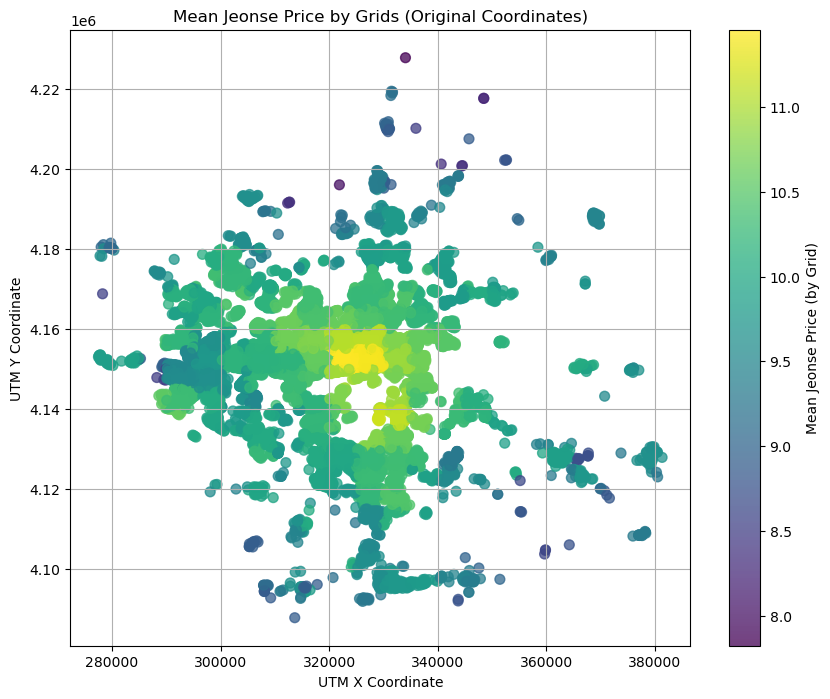

In [76]:
plt.figure(figsize=(10, 8))

# 아파트 위치(utm_x, utm_y)를 기반으로 전세가 평균을 색상으로 시각화
scatter = plt.scatter(merged_df['utm_x'], merged_df['utm_y'], 
                      c=merged_df['log_grid_mean'], cmap='viridis', s=50, alpha=0.75)

plt.colorbar(scatter, label='Mean Jeonse Price (by Grid)')

plt.title('Mean Jeonse Price by Grids (Original Coordinates)')
plt.xlabel('UTM X Coordinate')
plt.ylabel('UTM Y Coordinate')
plt.grid(True)
plt.show()